In [3]:
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
import torch

In [4]:
def project_theta(theta, m_values):
    projections = []
    for m in m_values:
        sin_m_theta = torch.sin(m * theta)
        cos_m_theta = torch.cos(m * theta)
        projected_vectors = torch.stack((cos_m_theta, sin_m_theta), axis=-1)
        projections.append(projected_vectors)
    return torch.stack(projections, axis=0)

def evaluate_functions_on_theta(theta, coefficients_list, m_values):
    evaluated_function = torch.zeros(theta.shape, dtype=torch.float32)    
    for (a_cos, a_sin), m in zip(coefficients_list, m_values):
        evaluated_function += a_sin * torch.sin(m * theta) + a_cos * torch.cos(m * theta)
    return evaluated_function

### Note, I think the columns and rows are showing x vs y respectively (opposite how we normally plot)
#### We can double check this later

## Load data and optimize offset

In [9]:
# Define parameters
ms = torch.arange(12)
angles = torch.arange(0, 6) * 2 * torch.pi / 6.

# Extract data_theta
data = np.load('/Users/cadenmyers/billingelab/dev/skyrmion_lattices/images/image_111020.npz')['data']
data_theta = torch.atan2(torch.tensor(data[1]), torch.tensor(data[0]))

# Extract data intensity and phi (unmasked)
movie = '121855.npz'
movie_images = np.load(f'/Users/cadenmyers/billingelab/dev/skyrmion_lattices/tests/{movie}')
movie_intensity = torch.tensor(movie_images['intensity'])
movie_intensity.shape

# Preprocess phi to get angle difference
# phi = training_data['phi'] - 253.1473
# print("phi:", phi)

[[[-0.02687761 -0.02687769 -0.02687777 ... -0.02687774 -0.02687766
   -0.02687757]
  [-0.02644178 -0.02644186 -0.02644195 ... -0.02644191 -0.02644183
   -0.02644175]
  [-0.02600594 -0.02600602 -0.0260061  ... -0.02600607 -0.02600599
   -0.02600591]
  ...
  [ 0.02763662  0.0276367   0.02763679 ...  0.02763675  0.02763667
    0.02763658]
  [ 0.0280724   0.02807249  0.02807258 ...  0.02807254  0.02807245
    0.02807236]
  [ 0.02850817  0.02850826  0.02850835 ...  0.02850832  0.02850823
    0.02850813]]

 [[-0.02760058 -0.02716478 -0.02672896 ...  0.02691393  0.02734974
    0.02778554]
  [-0.02760067 -0.02716486 -0.02672904 ...  0.02691401  0.02734982
    0.02778562]
  [-0.02760075 -0.02716495 -0.02672912 ...  0.02691409  0.02734991
    0.02778571]
  ...
  [-0.02760043 -0.02716463 -0.02672881 ...  0.02691378  0.02734959
    0.02778538]
  [-0.02760034 -0.02716454 -0.02672873 ...  0.02691369  0.0273495
    0.02778529]
  [-0.02760025 -0.02716445 -0.02672864 ...  0.02691361  0.02734941
    0.0

torch.Size([60, 128, 128])

In [40]:
# Made offset a required argument
def optimize_offset(intensity, offset):
    max_iter = 101
    opt = torch.optim.Adam([offset], lr=1e-2)
    for i in range(max_iter):
        projection = project_theta(angles + offset, ms).sum(1)
        evaluate_image_theta = evaluate_functions_on_theta(data_theta, projection, ms)
        loss = -(intensity * evaluate_image_theta).sum()
        opt.zero_grad()
        loss.backward()
        opt.step()
        #if i % 100 == 0:
        #    print(loss.item(), offset.item())
    return offset, evaluate_image_theta

offset =  torch.tensor(0.)
offset_list = []
offset.requires_grad = True
for i in range(movie_intensity.shape[0]):
    offset_ang, intensity = optimize_offset(movie_intensity[i], offset)
    print(f'{i}: offset angle=', offset_ang.item())
    offset_list.append(offset_ang.item())
    plt.plot(offset_list)

0: offset angle= 0.27126219868659973


In [21]:
optimize_offset(movie_intensity[0], torch.tensor(0.))

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [11]:
# Training
offset_list, evaluate_image_theta_list = [], []
offset = torch.tensor(0.)
offset.requires_grad = True
for intensity in movie_intensity:
    offset, evaluate_image_theta = optimize_offset(intensity, offset)
    offset_list.append(offset.item()), evaluate_image_theta_list.append(evaluate_image_theta)
print("offset in radius:", offset_list)

KeyboardInterrupt: 

In [19]:
# Note: we can probably decrease max_iter above.. I used 1501 because I wanted to see if it can improve accuracy
# Results
offset_diff_degrees = []
for offset in offset_list:
    # We're plotting y vs x instead of x vs y hence we need to use 90-offset instead of offset to compare with phi
    # -90+15.46960665870267 makes the first offset 0
    new_offset = 90 - offset/torch.pi*180 - 90 + 15.46960665870267
    offset_diff_degrees.append(new_offset)
print("offset (preprocessed) in degrees:", offset_diff_degrees)
# print("\nAbsolute errors:", np.abs(phi - offset_diff_degrees))

offset (preprocessed) in degrees: [-0.07257246747868251, -0.08075674165164415, -0.11241466845465098, 0.550070992354275, 2.871163932715941, 4.261194513725453, 6.222748857498612, 7.983318908528599, 8.28492640189803, 11.94281969774637, 13.137752755303634, 11.126604834853847, 12.690960199615485, 14.094433339963526, 12.751217836020626, 13.513529699757054, 13.746330827923114, 13.862472325065365, 18.387547995723093, 20.728131307768233, 21.484001449343676, 24.96269277948569, 28.179040812475744, 31.798094237608804, 36.0193321446897, 41.25968208726067, 43.899693635443185, 46.8479635736994, 50.37772678958653, 53.704203085206586, 55.022596934653706, 56.71933886788992, 59.085770603962146, 61.421848979362835, 60.95694873841134, 65.33728565692391, 68.68302650109797, 69.95181610169789, 70.20428721417824, 75.55078512664039, 76.64204445033332, 75.81964869312876, 76.65119690382113]


78.19985350566232


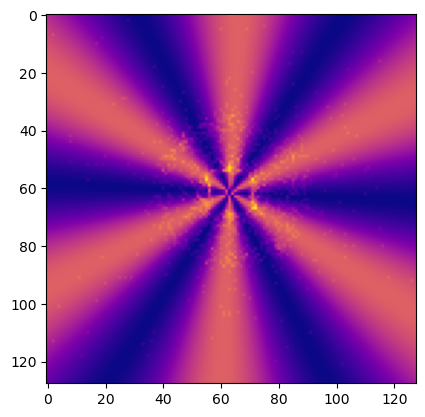

In [20]:
# The weird case (need a mask to train again)
the_offset = torch.tensor(-1.2826639413833618)
the_offset.requires_grad = True
the_offset, the_evaluate_image_theta = optimize_offset(movie_intensity[51], the_offset)
print(-the_offset.item()/torch.pi*180 + 15.46960665870267)
plt.imshow((the_evaluate_image_theta / the_evaluate_image_theta.abs().max() + movie_intensity[51] / movie_intensity[51].abs().max()).detach(), cmap='plasma')



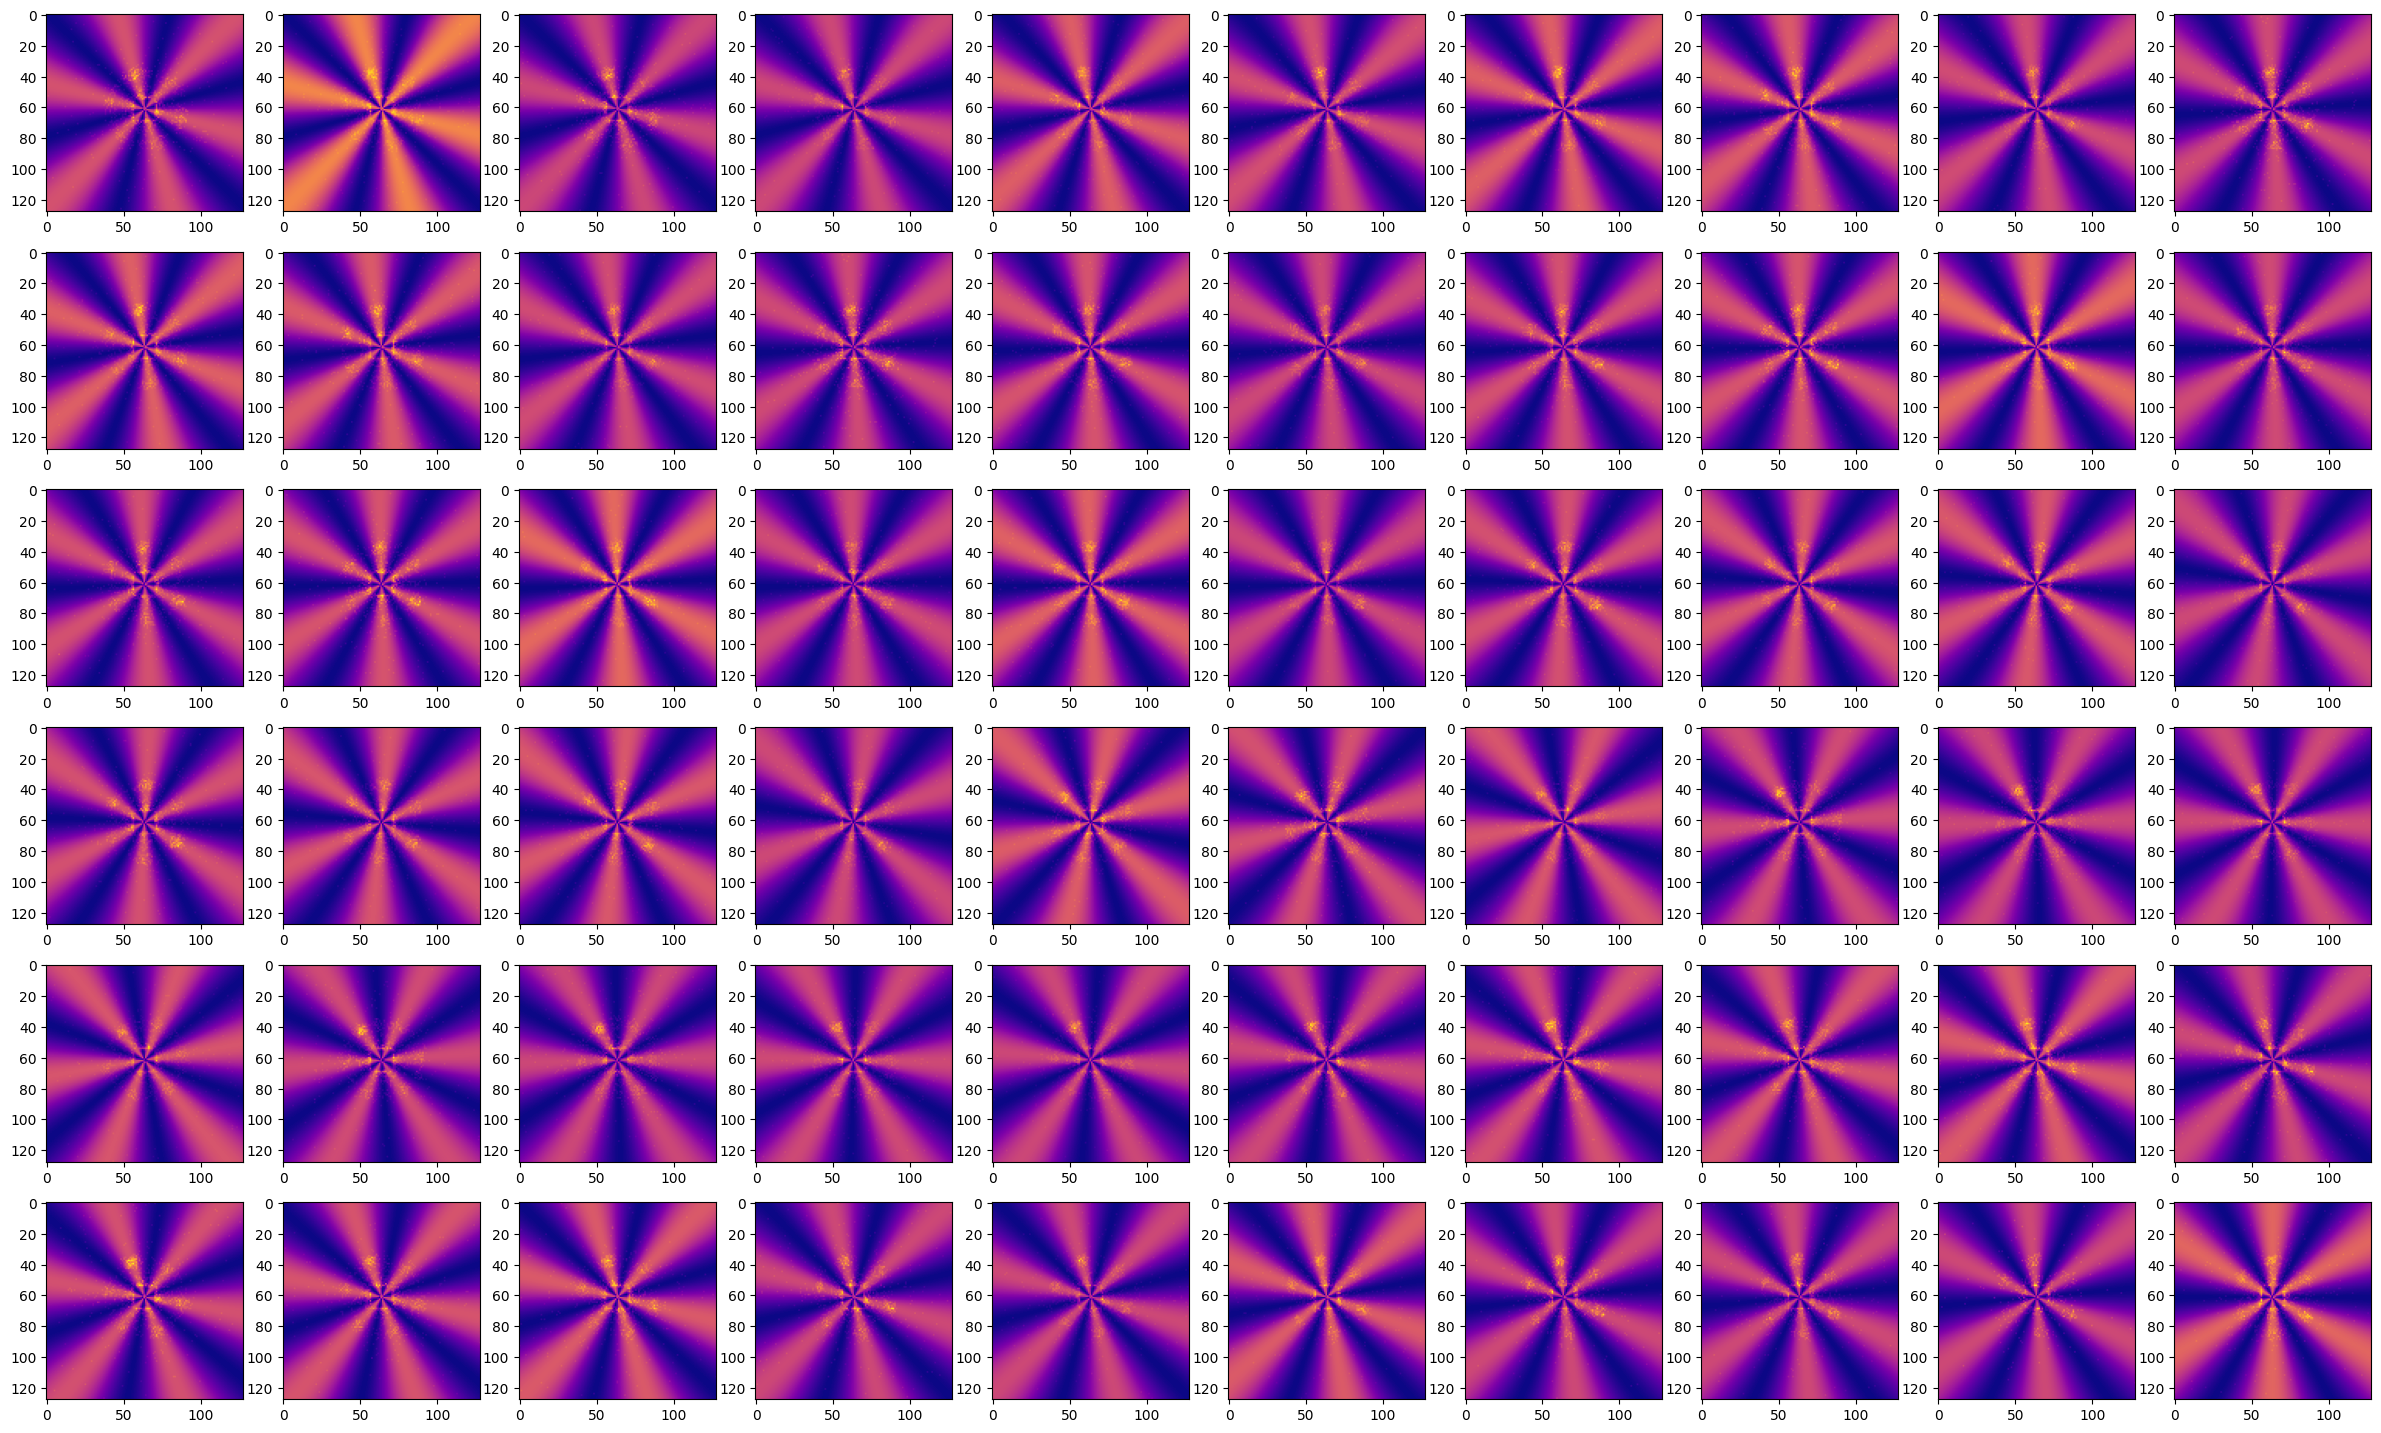

In [333]:
fig, ax = plt.subplots(nrows=6, ncols=10, figsize=(30, 18))
for i in range(6):
    for j in range(10):
        ax[i, j].imshow((evaluate_image_theta_list[i*6 + j] / evaluate_image_theta_list[i*6 + j].abs().max() + movie_intensity[i*6 + j] / movie_intensity[i*6 + j].abs().max()).detach(), cmap='plasma')

